# GPU-Accelerated Curve Fitting with Theseus

In [42]:
import numpy as np
from theseusqfls import genplanck
import torch
from scipy.optimize import curve_fit
import time
import h5py
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

In [2]:
energy = np.linspace(1.65, 1.75, 50)
qfls = 1.12*np.ones((1024, 1024)) + 0.01*(np.random.random((1024, 1024)) - 0.5)
gamma = 0.02*np.ones((1024, 1024)) + 0.002*(np.random.random((1024, 1024)) - 0.5)
theta = 1.5*np.ones((1024, 1024)) + 0.05*(np.random.random((1024, 1024)) - 0.5)
bandgap = 1.6*np.ones((1024, 1024)) + 0.05*(np.random.random((1024, 1024)) - 0.5)
pl = np.zeros((energy.size, qfls.shape[0], qfls.shape[1]))

In [3]:
exp_energy, exp_pl = genplanck.import_hyperspectral('data/example_photometric.h5')
exp_energy_crop, exp_pl_crop = genplanck.crop_data(exp_energy, exp_pl)
init_guesses = [1.2, 0.025, 1.5, 1.7]
points = [255, 511, 767]
guesses = np.zeros((4, len(points), len(points)))
for i in range(len(points)):
    for j in range(len(points)):
        guesses[:, i, j], __ = curve_fit(genplanck.gen_planck, exp_energy_crop, exp_pl_crop[:, i, j].squeeze(), p0=init_guesses)
guesses = list(np.mean(guesses, axis=(1, 2)))

C:\Users\cbc37\Desktop\theseusqfls\theseusqfls\genplanck_profiling.py:104: RuntimeWarning: invalid value encountered in sqrt
  part3 = (1 - math.e ** (-40 * np.sqrt(gamma) * eval_interp((energy - bandgap) / gamma, theta)))


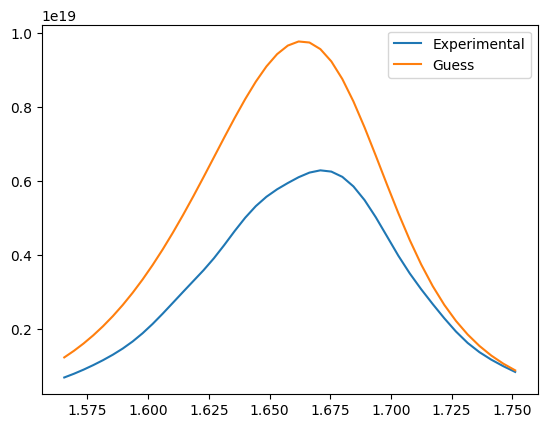

In [4]:
fig, ax = plt.subplots()
ax.plot(exp_energy_crop, np.mean(exp_pl_crop, axis=(1, 2)), label='Experimental')
ax.plot(exp_energy_crop, genplanck.gen_planck(exp_energy_crop, guesses[0], guesses[1], guesses[2], guesses[3]), label='Guess')
ax.legend()

In [21]:
result_6, info_6 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=10, step_size=1, accuracy=6, verbose=False)

100%|██████████| 512/512 [05:04<00:00,  1.68it/s]


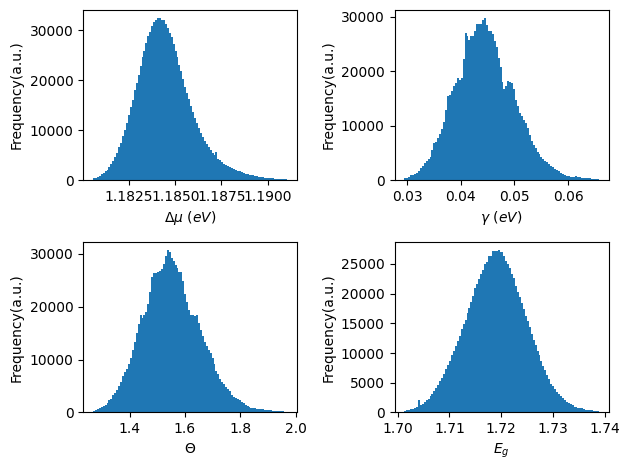

In [22]:
torch.cuda.empty_cache()
keys = ['qfls', 'gamma', 'theta', 'bandgap']
labels = ['$\Delta \mu\ (eV)$', '$\gamma \ (eV)$', '$\Theta$', '$E_g$']
n_bins = 100
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
for i in range(len(keys)):
    axs[i].hist(result_6[keys[i]], bins=n_bins,
                range=[np.nanpercentile(result_6[keys[i]], 0.1), np.nanpercentile(result_6[keys[i]], 99.9)]
                )
    axs[i].set(xlabel=labels[i], ylabel='Frequency(a.u.)')
fig.tight_layout()

In [17]:
result_4, info_4 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=10, step_size=1, accuracy=4, verbose=False)

100%|██████████| 512/512 [03:34<00:00,  2.39it/s]


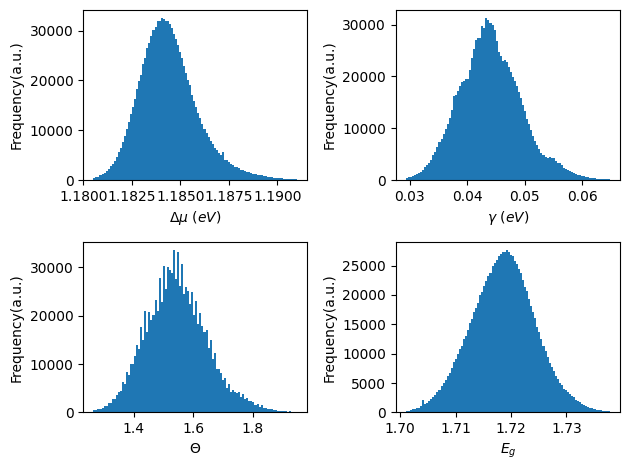

In [18]:
torch.cuda.empty_cache()
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
for i in range(len(keys)):
    axs[i].hist(result_4[keys[i]], bins=n_bins,
                range=[np.nanpercentile(result_4[keys[i]], 0.1), np.nanpercentile(result_4[keys[i]], 99.9)]
                )
    axs[i].set(xlabel=labels[i], ylabel='Frequency(a.u.)')
fig.tight_layout()

In [19]:
result_2, info_2 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=10, step_size=1, accuracy=2, verbose=False)

100%|██████████| 512/512 [02:00<00:00,  4.23it/s]


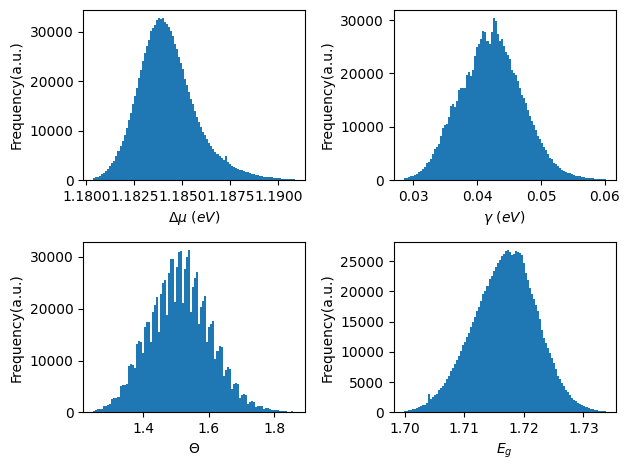

In [20]:
torch.cuda.empty_cache()
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
for i in range(len(keys)):
    axs[i].hist(result_2[keys[i]], bins=n_bins,
                range=[np.nanpercentile(result_2[keys[i]], 0.1), np.nanpercentile(result_2[keys[i]], 99.9)]
                )
    axs[i].set(xlabel=labels[i], ylabel='Frequency(a.u.)')
fig.tight_layout()

In [32]:
result_4_05, info_4_05 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=5, step_size=1, accuracy=4, verbose=False)

100%|██████████| 512/512 [01:56<00:00,  4.40it/s]


In [35]:
hist_4_05 = dict()
bins_4_05 = dict()
n_bins = 100
for key in keys:
    hist_4_05[key], bins_4_05[key] = np.histogram(result_4_05[key], bins=n_bins, range=(np.percentile(result_4_05[key], 1), np.percentile(result_4_05[key], 99)))

In [23]:
result_4_10, info_4_10 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=10, step_size=1, accuracy=4, verbose=False)

100%|██████████| 512/512 [03:34<00:00,  2.39it/s]


In [27]:
hist_4_10 = dict()
bins_4_10 = dict()
n_bins = 100
for key in keys:
    hist_4_10[key], bins_4_10[key] = np.histogram(result_4_10[key], bins=n_bins, range=(np.percentile(result_4_10[key], 1), np.percentile(result_4_10[key], 99)))

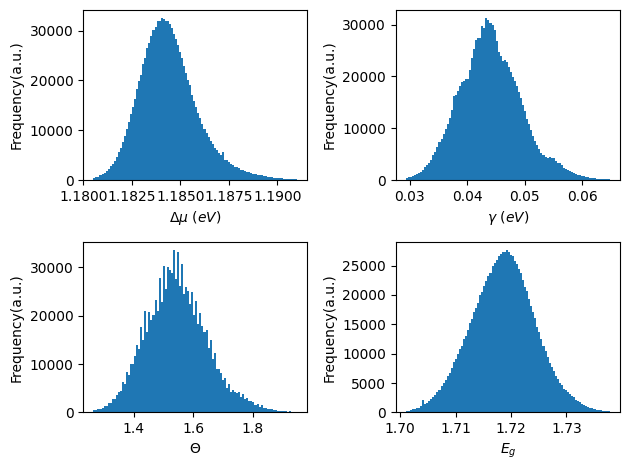

In [24]:
torch.cuda.empty_cache()
fig, axs = plt.subplots(2, 2)
axs = axs.flatten()
for i in range(len(keys)):
    axs[i].hist(result_4_10[keys[i]], bins=n_bins,
                range=[np.nanpercentile(result_4_10[keys[i]], 0.1), np.nanpercentile(result_4_10[keys[i]], 99.9)]
                )
    axs[i].set(xlabel=labels[i], ylabel='Frequency(a.u.)')
fig.tight_layout()

In [25]:
result_4_15, info_4_15 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=15, step_size=1, accuracy=4, verbose=False)

100%|██████████| 512/512 [05:09<00:00,  1.65it/s]


In [28]:
hist_4_15 = dict()
bins_4_15 = dict()
n_bins = 100
for key in keys:
    hist_4_15[key], bins_4_15[key] = np.histogram(result_4_15[key], bins=n_bins, range=(np.percentile(result_4_15[key], 1), np.percentile(result_4_15[key], 99)))

In [26]:
result_4_20, info_4_20 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=20, step_size=1, accuracy=4, verbose=False)

100%|██████████| 512/512 [06:46<00:00,  1.26it/s]


In [29]:
hist_4_20 = dict()
bins_4_20 = dict()
n_bins = 100
for key in keys:
    hist_4_20[key], bins_4_20[key] = np.histogram(result_4_20[key], bins=n_bins, range=(np.percentile(result_4_20[key], 1), np.percentile(result_4_20[key], 99)))

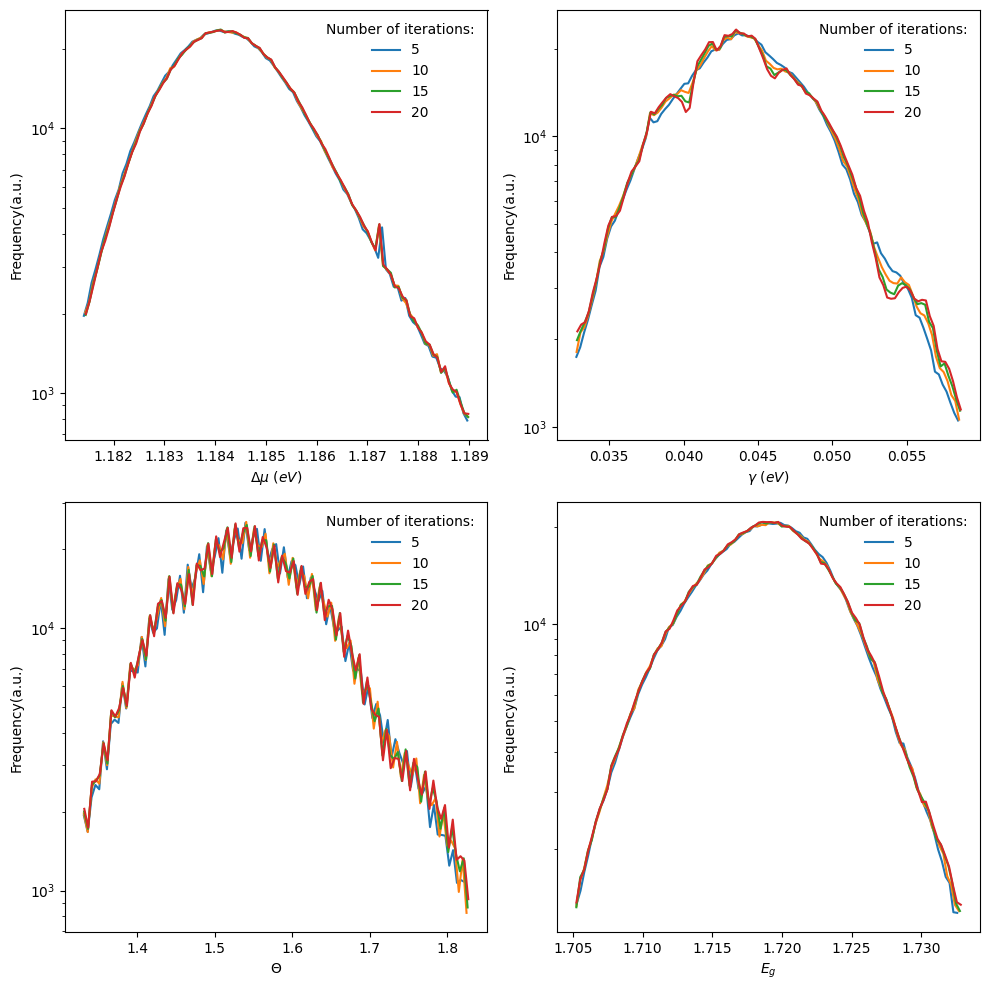

In [40]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
axs = axs.flatten()
for i in range(len(keys)):
    axs[i].plot(bins_4_05[keys[i]][1:], hist_4_05[keys[i]], label=5)
    axs[i].plot(bins_4_10[keys[i]][1:], hist_4_10[keys[i]], label=10)
    axs[i].plot(bins_4_15[keys[i]][1:], hist_4_15[keys[i]], label=15)
    axs[i].plot(bins_4_20[keys[i]][1:], hist_4_20[keys[i]], label=20)
    axs[i].set_yscale('log')
    axs[i].legend(title='Number of iterations:', loc='upper right', frameon=False)
    axs[i].set(xlabel=labels[i], ylabel='Frequency(a.u.)')
fig.tight_layout()
plt.show()

In [41]:
torch.cuda.empty_cache()

In [44]:
exp_pl_crop_64 = ndimage.zoom(exp_pl_crop, (1, 64/1024, 64/1024))
exp_pl_crop_128 = ndimage.zoom(exp_pl_crop, (1, 128/1024, 128/1024))
exp_pl_crop_256 = ndimage.zoom(exp_pl_crop, (1, 256/1024, 256/1024))
exp_pl_crop_512 = ndimage.zoom(exp_pl_crop, (1, 512/1024, 512/1024))
exp_pl_crop_1024 = exp_pl_crop

In [45]:
result_64, info_64 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_64, guesses=guesses, batch_size=2048, max_iterations=10, step_size=0.75, accuracy=4, verbose=False)
result_128, info_128 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_128, guesses=guesses, batch_size=2048, max_iterations=10, step_size=0.75, accuracy=4, verbose=False)
result_256, info_256 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_256, guesses=guesses, batch_size=2048, max_iterations=10, step_size=0.75, accuracy=4, verbose=False)
result_512, info_512 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_512, guesses=guesses, batch_size=2048, max_iterations=10, step_size=0.75, accuracy=4, verbose=False)
result_1024, info_1024 = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_1024, guesses=guesses, batch_size=2048, max_iterations=10, step_size=0.75, accuracy=4, verbose=False)

100%|██████████| 512/512 [03:32<00:00,  2.41it/s]


In [55]:
result_2its = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_1024, guesses=guesses, batch_size=2048, max_iterations=2, step_size=0.75, accuracy=4, verbose=False)
result_4its = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_1024, guesses=guesses, batch_size=2048, max_iterations=4, step_size=0.75, accuracy=4, verbose=False)
result_6its = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_1024, guesses=guesses, batch_size=2048, max_iterations=6, step_size=0.75, accuracy=4, verbose=False)
result_8its = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_1024, guesses=guesses, batch_size=2048, max_iterations=8, step_size=0.75, accuracy=4, verbose=False)
result_10its = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop_1024, guesses=guesses, batch_size=2048, max_iterations=10, step_size=0.75, accuracy=4, verbose=False)

100%|██████████| 512/512 [03:33<00:00,  2.39it/s]


In [59]:
index = 200
pl_0its = genplanck.gen_planck(exp_energy_crop, guesses[0], guesses[1], guesses[2], guesses[3])
pl_2its = genplanck.gen_planck(exp_energy_crop, result_2its['qfls'][index], result_2its['gamma'][index], result_2its['theta'][index], result_2its['bandgap'][index])
pl_4its = genplanck.gen_planck(exp_energy_crop, result_4its['qfls'][index], result_4its['gamma'][index], result_4its['theta'][index], result_4its['bandgap'][index])
pl_6its = genplanck.gen_planck(exp_energy_crop, result_6its['qfls'][index], result_6its['gamma'][index], result_6its['theta'][index], result_6its['bandgap'][index])
pl_8its = genplanck.gen_planck(exp_energy_crop, result_8its['qfls'][index], result_8its['gamma'][index], result_8its['theta'][index], result_8its['bandgap'][index])
pl_10its = genplanck.gen_planck(exp_energy_crop, result_10its['qfls'][index], result_10its['gamma'][index], result_10its['theta'][index], result_10its['bandgap'][index])

In [ ]:
rd_pu_6 = ['#7a0177', '#ae017e', '#dd3497', '#f768a1', '#fa9fb5', '#fcc5c0']
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot(exp_energy_crop, exp_pl_crop.reshape(exp_pl_crop.shape[0], -1)[:, index], ' ok', label='Experimental')
ax.plot(exp_energy_crop, pl_0its, color=rd_pu_6[0], label=0)
ax.plot(exp_energy_crop, pl_2its, color=rd_pu_6[1], label=2)
ax.plot(exp_energy_crop, pl_4its, color=rd_pu_6[2], label=4)
ax.plot(exp_energy_crop, pl_6its, color=rd_pu_6[3], label=6)
ax.plot(exp_energy_crop, pl_8its, color=rd_pu_6[4], label=8)
ax.plot(exp_energy_crop, pl_10its, color=rd_pu_6[5], label=10)
ax.set(xlabel='Energy (eV)', ylabel='$I_{PL}\ (eV^{-1}m^{-2}s^{-1})$')
ax.legend(title='Number of Iterations', frameon=False, fontsize='small')
plt.savefig("G:/Shared drives/StranksLab/Personal Folders/Cullen Chosy/Presentations/Group Meeting - 27 1 23/figures/fitting_iterations.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
hist_2its = dict()
bins_2its = dict()
n_bins = 100
for key in keys:
    hist_2its[key], bins_2its[key] = np.histogram(result_2its[key], bins=n_bins, range=(np.percentile(result_2its[key], 1), np.percentile(result_2its[key], 99)))

In [ ]:
hist_4its = dict()
bins_4its = dict()
n_bins = 100
for key in keys:
    hist_4its[key], bins_4its[key] = np.histogram(result_4its[key], bins=n_bins, range=(np.percentile(result_4its[key], 1), np.percentile(result_4its[key], 99)))

In [ ]:
hist_6its = dict()
bins_6its = dict()
n_bins = 100
for key in keys:
    hist_6its[key], bins_6its[key] = np.histogram(result_6its[key], bins=n_bins, range=(np.percentile(result_6its[key], 1), np.percentile(result_6its[key], 99)))

In [ ]:
hist_8its = dict()
bins_8its = dict()
n_bins = 100
for key in keys:
    hist_8its[key], bins_8its[key] = np.histogram(result_8its[key], bins=n_bins, range=(np.percentile(result_8its[key], 1), np.percentile(result_8its[key], 99)))

In [ ]:
hist_10its = dict()
bins_10its = dict()
n_bins = 100
for key in keys:
    hist_10its[key], bins_10its[key] = np.histogram(result_10its[key], bins=n_bins, range=(np.percentile(result_10its[key], 1), np.percentile(result_10its[key], 99)))

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
axs = axs.flatten()
for i in range(len(keys)):
    axs[i].plot(bins_2its[keys[i]][1:], hist_2its[keys[i]], color=rd_pu_6[1], label=2)
    axs[i].plot(bins_4its[keys[i]][1:], hist_4its[keys[i]], color=rd_pu_6[2], label=4)
    axs[i].plot(bins_6its[keys[i]][1:], hist_6its[keys[i]], color=rd_pu_6[3], label=6)
    axs[i].plot(bins_8its[keys[i]][1:], hist_8its[keys[i]], color=rd_pu_6[4], label=8)
    axs[i].plot(bins_10its[keys[i]][1:], hist_10its[keys[i]], color=rd_pu_6[5], label=10)
    axs[i].set_yscale('log')
    axs[i].legend(title='Number of iterations:', loc='upper right', frameon=False, alignment='right', title_fontsize='x-small', fontsize='x-small')
    axs[i].set(xlabel=labels[i], ylabel='Frequency (a.u.)')
fig.tight_layout()
plt.savefig("G:/Shared drives/StranksLab/Personal Folders/Cullen Chosy/Presentations/Group Meeting - 27 1 23/figures/fitting_params_iterations.png", dpi=300, bbox_inches='tight')
plt.show()

In [79]:
hist_2its = dict()
bins_2its = dict()
n_bins = 100
for key in keys:
    hist_2its[key], bins_2its[key] = np.histogram(result_2its[key], bins=n_bins, range=(np.percentile(result_2its[key], 1), np.percentile(result_2its[key], 99)))

In [80]:
hist_4its = dict()
bins_4its = dict()
n_bins = 100
for key in keys:
    hist_4its[key], bins_4its[key] = np.histogram(result_4its[key], bins=n_bins, range=(np.percentile(result_4its[key], 1), np.percentile(result_4its[key], 99)))

In [81]:
hist_6its = dict()
bins_6its = dict()
n_bins = 100
for key in keys:
    hist_6its[key], bins_6its[key] = np.histogram(result_6its[key], bins=n_bins, range=(np.percentile(result_6its[key], 1), np.percentile(result_6its[key], 99)))

In [82]:
hist_8its = dict()
bins_8its = dict()
n_bins = 100
for key in keys:
    hist_8its[key], bins_8its[key] = np.histogram(result_8its[key], bins=n_bins, range=(np.percentile(result_8its[key], 1), np.percentile(result_8its[key], 99)))

In [83]:
hist_10its = dict()
bins_10its = dict()
n_bins = 100
for key in keys:
    hist_10its[key], bins_10its[key] = np.histogram(result_10its[key], bins=n_bins, range=(np.percentile(result_10its[key], 1), np.percentile(result_10its[key], 99)))

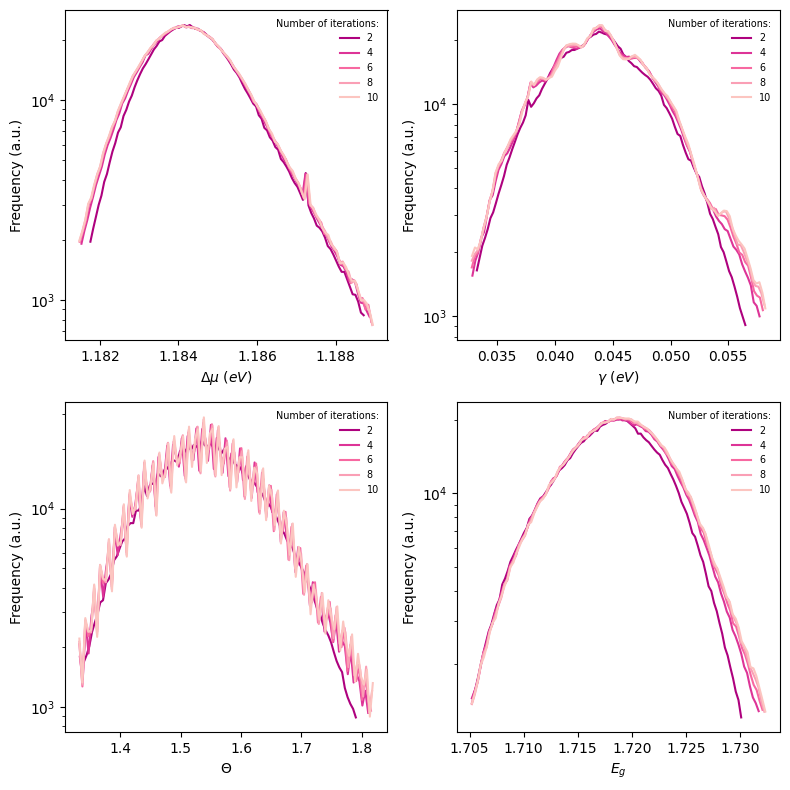

In [93]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)
axs = axs.flatten()
for i in range(len(keys)):
    axs[i].plot(bins_2its[keys[i]][1:], hist_2its[keys[i]], color=rd_pu_6[1], label=2)
    axs[i].plot(bins_4its[keys[i]][1:], hist_4its[keys[i]], color=rd_pu_6[2], label=4)
    axs[i].plot(bins_6its[keys[i]][1:], hist_6its[keys[i]], color=rd_pu_6[3], label=6)
    axs[i].plot(bins_8its[keys[i]][1:], hist_8its[keys[i]], color=rd_pu_6[4], label=8)
    axs[i].plot(bins_10its[keys[i]][1:], hist_10its[keys[i]], color=rd_pu_6[5], label=10)
    axs[i].set_yscale('log')
    axs[i].legend(title='Number of iterations:', loc='upper right', frameon=False, alignment='right', title_fontsize='x-small', fontsize='x-small')
    axs[i].set(xlabel=labels[i], ylabel='Frequency (a.u.)')
fig.tight_layout()
plt.savefig("G:/Shared drives/StranksLab/Personal Folders/Cullen Chosy/Presentations/Group Meeting - 27 1 23/figures/fitting_params_iterations.png", dpi=300, bbox_inches='tight')
plt.show()